# Localization & Segmentation

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:08, 90.7MB/s]


'oxford_pet.zip'

In [3]:
## oxford_pet.zip 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Oct 30 10:27 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Oct 28 16:30 sample_data


In [4]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [5]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


## Data 준비

In [6]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [7]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

3686

In [8]:
## segmentation을 위한 annotation file 수 확인(segmentation file은 확장자가 png로 되어 있음)
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png']
len(seg_files)

7390

In [9]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [10]:
## 개와 고양이 directory 생성
dog_dir = os.path.join(data_dir, 'dogs')
cat_dir = os.path.join(data_dir, 'cats')
os.makedirs(dog_dir, exist_ok=True)
os.makedirs(cat_dir, exist_ok=True)

In [11]:
''' localization label 수가 적기 때문에, localization label이 있는 directory에서
bbox label file을 하나씩 읽고, 같은 이름의 image file을 찾은 뒤
image file 중 개 이미지는 dogs 디렉토리에, 고양이 이미지는 cats 디렉토리에 복사
file 이름의 첫 글자가 대문자로 시작하면 고양이, 소문자로 시작하면 개의 image임을 이용함'''

cat_cnt = 0
dog_cnt = 0
for bbox_file in bbox_files:
  file_name = os.path.splitext(bbox_file)[0]
  image_name = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_name)
  ## file 이름의 첫글자가 소문자인지 확인: 개
  if image_name[0].islower():
    dog_cnt += 1
    copy_path = os.path.join(dog_dir, image_name)
  ## file 이름 첫글자가 대문자인 경우: 고양이
  else:
    cat_cnt += 1
    copy_path = os.path.join(cat_dir, image_name)
  ## image copy
  shutil.copy(image_path, copy_path)

In [12]:
print("총 복사된 image 수: {}".format(dog_cnt+cat_cnt))
print("개 image 수: {}".format(dog_cnt))
print("고양이 image 수: {}".format(cat_cnt))

총 복사된 image 수: 3686
개 image 수: 2498
고양이 image 수: 1188


In [13]:
## validation data를 나누기 위한 directory 생성
val_dir = os.path.join(data_dir, 'dogs_val')
os.makedirs(val_dir, exist_ok=True)

In [14]:
## train data와 validation data를 나누기 위한 index 생성
train_idx, val_idx = train_test_split(np.arange(dog_cnt), train_size=0.80065)

In [16]:
## train, validation data 수 확인
print("train data의 수: {}".format(train_idx.shape[0]))
print("validation data의 수: {}".format(val_idx.shape[0]))

train data의 수: 2000
validation data의 수: 498


In [17]:
## validation data를 validation directory로 이동
dog_files = os.listdir(dog_dir)

val_cnt = 0
for idx, dog_file in enumerate(dog_files):
    dog_path = os.path.join(dog_dir, dog_file)
    val_path = os.path.join(val_dir, dog_file)
    if idx in val_idx:
        shutil.move(dog_path, val_path)
        val_cnt += 1
print(val_cnt)
print(dog_cnt - val_cnt)

498
2000


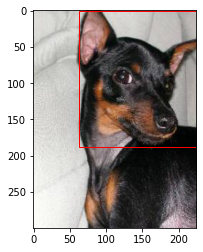

In [18]:
# 임의의 image를 가져와서, bbox와 seg map 확인

fnames = os.listdir(dog_dir)
rnd_idx = random.randint(1, len(fnames))
fname = fnames[rnd_idx]

fpath = os.path.join(dog_dir, fname)
img = Image.open(fpath)
img = np.array(img)

## bbox label parsing  
bbox_name = os.path.splitext(fname)[0] + '.xml'
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)
## xml file parsing
width = float(tree.find('./size/width').text)
height = float(tree.find('./size/height').text)
xmin = float(tree.find('./object/bndbox/xmin').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymax = float(tree.find('./object/bndbox/ymax').text)
## 사각형을 그리기 위해서 왼쪽 위 꼭지점 좌표와, bbox의 widgh, height 계산
rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(img)
plt.show()

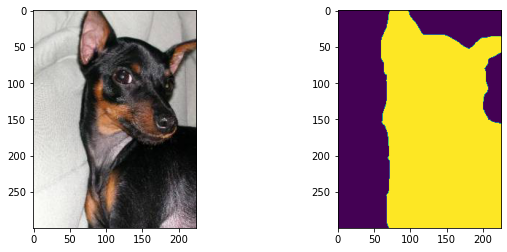

In [19]:
## segmentation label
## 원래 label은 1: foreground, 2: background, 3: not classified 로 구성됨
## 이것을 0: background, 1 : foreground & not classified로 변경
sname = os.path.splitext(fname)[0] + '.png'
spath = os.path.join(seg_dir, sname)    
seg = Image.open(spath)
seg = np.array(seg)
seg[seg>2] = 1
seg[seg==2] = 0

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(seg)
plt.show()

## TFRecord 만들기

In [20]:
IMG_SIZE = 224

In [21]:
## tfrecord 파일 저장할 directory 생성 및 파일 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'train.tfrecord')
tfr_val_dir = os.path.join(tfr_dir, 'val.tfrecord')

In [22]:
## tfrecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [23]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [24]:
## train data의 tfrecord file 생성
n_train = 0
train_dir = dog_dir
train_files = os.listdir(train_dir)
for train_file in train_files:
  ## input image를 resize 후 bytes로 변경
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  ## bbox label parsing
  '''bounding box의 정보가 있는 xml file을 열어서 좌표 정보를 parsing한 후,
    boudnign box의 중심점의 x, y 좌표와 width, height를 계산함
    이 때 0~1사이의 값이 되도록 width와 height로 나눠줌'''
  bbox_name = os.path.splitext(train_file)[0] + '.xml'
  bbox_path = os.path.join(bbox_dir, bbox_name)
  tree = et.parse(bbox_path)
  ## xml file parsing
  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  ## x, y, w, h 계산
  xc = (xmin+xmax)/2.
  yc = (ymin+ymax)/2.
  x = xc/width
  y = yc/height
  w = (xmax-xmin)/width
  h = (ymax-ymin)/height

  ## segmentation label을 resize후 bytes로 변경
  seg_name = os.path.splitext(train_file)[0] + '.png'
  seg_path = os.path.join(seg_dir, seg_name)
  seg = Image.open(seg_path)
  seg = seg.resize((IMG_SIZE, IMG_SIZE))
  seg = np.array(seg)
  seg[seg>2] = 1
  seg[seg==2] = 0
  bseg = seg.tobytes()


  ## tfrecord file로 write
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'x': _float_feature(x),
            'y': _float_feature(y),
            'w': _float_feature(w),
            'h': _float_feature(h),
            'seg': _bytes_feature(bseg)}))
  writer_train.write(example.SerializeToString())
  n_train += 1

print(n_train)

2000


In [25]:
## train data의 tfrecord file 생성
n_val = 0
val_files = os.listdir(val_dir)
for val_file in val_files:
  ## input image를 resize 후 bytes로 변경
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  ## bbox label parsing
  '''bounding box의 정보가 있는 xml file을 열어서 좌표 정보를 parsing한 후,
    boudnign box의 중심점의 x, y 좌표와 width, height를 계산함
    이 때 0~1사이의 값이 되도록 width와 height로 나눠줌'''
  bbox_name = os.path.splitext(val_file)[0] + '.xml'
  bbox_path = os.path.join(bbox_dir, bbox_name)
  tree = et.parse(bbox_path)
  ## xml file parsing
  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  ## x, y, w, h 계산
  xc = (xmin+xmax)/2.
  yc = (ymin+ymax)/2.
  x = xc/width
  y = yc/height
  w = (xmax-xmin)/width
  h = (ymax-ymin)/height

  ## segmentation label을 resize후 bytes로 변경
  seg_name = os.path.splitext(val_file)[0] + '.png'
  seg_path = os.path.join(seg_dir, seg_name)
  seg = Image.open(seg_path)
  seg = seg.resize((IMG_SIZE, IMG_SIZE))
  seg = np.array(seg)
  seg[seg>2] = 1
  seg[seg==2] = 0
  bseg = seg.tobytes()


  ## tfrecord file로 write
  example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(bimage),
            'x': _float_feature(x),
            'y': _float_feature(y),
            'w': _float_feature(w),
            'h': _float_feature(h),
            'seg': _bytes_feature(bseg)}))
  writer_val.write(example.SerializeToString())
  n_val += 1

print(n_val)

498


In [26]:
!ls oxford_pet/tfrecord

train.tfrecord	val.tfrecord


In [27]:
writer_train.close()
writer_val.close()

## Image Localization

In [28]:
## Hyper Parameters
N_EPOCHS = 20
N_BATCH = 20
N_TRAIN = 2000
N_VAL = 498
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = int(N_TRAIN / N_BATCH)
validation_steps = int(np.ceil(N_VAL / N_BATCH))
print(steps_per_epoch, validation_steps)

100 25


In [29]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32),
              'seg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [30]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [31]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_VAL).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

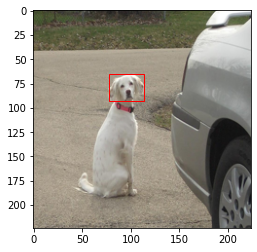

In [32]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(1):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

In [33]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [34]:
## MobileNet V2의 pretrained model을 load
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [35]:
## localization을 위한 network
## mobilenet v2 구조에 fully connected layer 3개를 추가하고 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
model = models.Sequential()
model.add(mobilenetv2)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

In [36]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.3,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [37]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/20
100/100 [==============================] - 13s 125ms/step - loss: 0.0379 - val_loss: 0.0310
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0182 - val_loss: 0.0250
Epoch 3/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0112 - val_loss: 0.0193
Epoch 4/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0086 - val_loss: 0.0152
Epoch 5/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0069 - val_loss: 0.0147
Epoch 6/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0059 - val_loss: 0.0115
Epoch 7/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0051 - val_loss: 0.0108
Epoch 8/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 9/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0042 - val_loss: 0.0088
Epoch 10/20
100/100 [==============================] - 12s 118ms/step - l

In [38]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = 20
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[0] - pred_w[0]/2.
    pred_ymin = pred_y[0] - pred_h[0]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[0] * IMG_SIZE)
    pred_rect_h = int(pred_h[0] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[0])
    plt.show()
    idx += 1

Output hidden; open in https://colab.research.google.com to view.

## Image Segmentation

In [39]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32),
              'seg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)
    seg = tf.reshape(seg, [IMG_SIZE, IMG_SIZE, -1])
    seg = tf.cast(seg, tf.float32)
    
    return image, seg

In [40]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [41]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=N_VAL).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

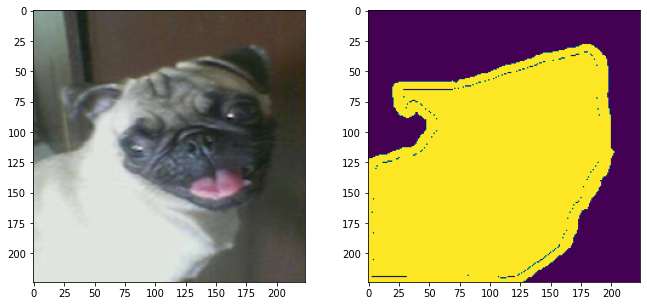

In [42]:
## train dataset에서 1개의 image와 segmentation label을 읽어서 확인
for image, seg in val_dataset.take(1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1) 
    plt.show()

In [43]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [44]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

58892288/58889256 [==============================] - 1s 0us/step


In [45]:
def create_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    ## loading vgg16 pretrained weights
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 

In [46]:
model = create_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [47]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [48]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/20
100/100 [==============================] - 59s 589ms/step - loss: 0.4117 - sparse_categorical_accuracy: 0.8077 - val_loss: 0.2353 - val_sparse_categorical_accuracy: 0.9052
Epoch 2/20
100/100 [==============================] - 58s 577ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.1773 - val_sparse_categorical_accuracy: 0.9301
Epoch 3/20
100/100 [==============================] - 58s 577ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.1568 - val_sparse_categorical_accuracy: 0.9395
Epoch 4/20
100/100 [==============================] - 58s 577ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.1563 - val_sparse_categorical_accuracy: 0.9417
Epoch 5/20
100/100 [==============================] - 58s 577ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.1484 - val_sparse_categorical_accuracy: 0.9433
Epoch 6/20
100/100 [==============================] - 58s 576ms/step - loss: 0.1069 -

In [49]:
## num_imgs만큼 validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)

    plt.subplot(num_imgs,3,idx*3+3)
    ## validation data에 대한 예측값 생성
    prediction = model.predict(image)    
    pred = np.zeros_like(prediction)
    ## 0.5이상은 1로 나머지는 0으로 변환
    thr = 0.5
    pred[prediction>=thr] = 1
    pred[prediction<thr] = 0
    plt.imshow(pred[0,:,:,1])
    plt.show() 
    idx += 1

Output hidden; open in https://colab.research.google.com to view.